# BESSTIE Benchmark Fine-Tuning with Mistral-2B-Instruct

This notebook replicates the BESSTIE benchmark fine-tuning using Mistral-2B-Instruct with QLoRA quantization.

## Task Overview:
- Fine-tune Mistral-2B-Instruct for classification across three English varieties: en-AU, en-IN, en-UK
- Handle three data sections: google-sentiment, reddit-sentiment, reddit-sarcasm
- Cross-variety experimental loop with evaluation
- Generate 3x3 heatmaps showing F1-scores

## Section 1: Setup and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/emirmasood/FLUTransformer.git

Cloning into 'FLUTransformer'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 123 (delta 54), reused 50 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 1.93 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Filtering content: 100% (8/8), 166.32 MiB | 51.86 MiB/s, done.


In [2]:
# Install required packages (run once)
#!pip install transformers peft bitsandbytes datasets scikit-learn accelerate torch
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install datasets scikit-learn

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-qb8ye1ii/unsloth_1e7c12cbc2e3440c8a47fe4507f1dbac
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-qb8ye1ii/unsloth_1e7c12cbc2e3440c8a47fe4507f1dbac
  Resolved https://github.com/unslothai/unsloth.git to commit d59ee86feeca4e0f63964d6fa7986a3d8d343a4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 149.5 MB/s eta 0:00:00

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from tqdm.auto import tqdm

from unsloth import FastLanguageModel
from transformers import TrainingArguments
from trl import SFTTrainer

from datasets import load_dataset, Dataset
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Using device: cuda


## Section 2: Configuration and Constants

In [4]:
# Model configuration
MODEL_NAME = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
#MODEL_NAME = "unsloth/Mistral-Small-Instruct-2409-bnb-4bit"

OUTPUT_DIR = "/content/drive/MyDrive/mistral_besstie_outputs"
RESULTS_DIR = "/content/drive/MyDrive/mistral_besstie_results"
CHECKPOINT_DIR = "/content/drive/MyDrive/checkpoints"

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Varieties and tasks
VARIETIES = ["en-AU", "en-IN", "en-UK"]
TASKS = ["google-sentiment", "reddit-sentiment", "reddit-sarcasm"]

# Training hyperparameters
MAX_EPOCHS = 5
LEARNING_RATE = 2e-4
BATCH_SIZE = 1
EARLY_STOPPING_PATIENCE = 3
EARLY_STOPPING_THRESHOLD = 0.1  # 10% improvement threshold
GRADIENT_ACCUMULATION_STEPS = 16
# LoRA hyperparameters
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
MAX_SEQ_LENGTH = 1024

# Prompts
SENTIMENT_PROMPT = "Generate the sentiment of the given text. 1 for positive sentiment, and 0 for negative sentiment. Do not give an explanation."
SARCASM_PROMPT = "Predict if the given text is sarcastic. 1 if the text is sarcastic, and 0 if the text is not sarcastic. Do not give an explanation."

print("Configuration loaded successfully!")

Configuration loaded successfully!


## Section 3: Data Loading and Preparation

In [5]:
# Load BESSTIE dataset
dataset = load_dataset("unswnlporg/BESSTIE")

print("Dataset loaded successfully!")
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['validation'])}")
print(f"\nDataset features: {dataset['train'].features}")
print(f"\nSample entry: {dataset['train'][0]}")

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/17760 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2428 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 17760
Test samples: 2428

Dataset features: {'text': Value('string'), 'label': Value('int64'), 'variety': Value('string'), 'source': Value('string'), 'task': Value('string')}

Sample entry: {'text': "This was one of the best dishes I've EVER had! I have very high standards, and I also comparing to Melbourne cafes. There was a generous amount of mushrooms, perfectly cooked. There was an AMAZING onion jam thing, the truffle mayo was absolutely incredible! Very reasonably priced. I asked for sourdough instead of brioche which was happily done, but the bread was very soggy when I got the plate. I could move to Mackay just for this And as vegetarians, I REALLY appreciate you for not charging us the extra 4 for replacing the bacon with avo in your ' bacon and eggs '. 80 % of places make you pay for substituting the meat for vegetables:", 'label': 1, 'variety': 'en-AU', 'source': 'Google', 'task': 'Sentiment'}


In [6]:
def create_stratified_splits(dataset, variety, task, val_size=0.1):
    """
    Create stratified train/validation splits for a specific variety and task.

    Args:
        dataset: HuggingFace dataset
        variety: One of ["en-AU", "en-IN", "en-UK"]
        task: One of ["google-sentiment", "reddit-sentiment", "reddit-sarcasm"]
        val_size: Validation split size (default: 0.1 for 10%)

    Returns:
        train_data, val_data, test_data
    """
    # Filter by variety and task
    train_df = dataset['train'].to_pandas()
    test_df = dataset['validation'].to_pandas()

    # Map task names
    task_mapping = {
        "google-sentiment": "Sentiment",
        "reddit-sentiment": "Sentiment",
        "reddit-sarcasm": "Sarcasm"
    }

    # Determine source filter
    if "google" in task:
        source_filter = "Google"
    else:
        source_filter = "Reddit"

    task_type = task_mapping[task]

    # Filter training data
    train_filtered = train_df[
        (train_df['variety'] == variety) &
        (train_df['task'] == task_type) &
        (train_df['source'] == source_filter)
    ].copy()

    # Filter test data
    test_filtered = test_df[
        (test_df['variety'] == variety) &
        (test_df['task'] == task_type) &
        (test_df['source'] == source_filter)
    ].copy()

    # Create stratified train/val split
    if len(train_filtered) > 0:
        train_data, val_data = train_test_split(
            train_filtered,
            test_size=val_size,
            stratify=train_filtered['label'],
            random_state=SEED
        )
    else:
        train_data = train_filtered
        val_data = pd.DataFrame()

    return train_data, val_data, test_filtered

print("Data splitting function defined!")

Data splitting function defined!


## Section 4: Tokenizer and Model Setup with QLoRA

In [7]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

def get_unsloth_model():
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        max_seq_length=MAX_SEQ_LENGTH,
        load_in_4bit=True,
    )

    # DYNAMICALLY FIND ALL LINEAR LAYERS (Source Code Method)
    modules = find_all_linear_names(model)

    model = FastLanguageModel.get_peft_model(
        model,
        r=16, # Source code uses r=16
        target_modules=modules, # Targeted all identified layers
        lora_alpha=32,
        lora_dropout=LORA_DROPOUT, # Source code uses 0.05
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=SEED,
    )
    return model, tokenizer

print("Tokenizer loaded successfully!")

Tokenizer loaded successfully!


## Section 5: Instruction Formatting and Dataset Preparation

In [8]:
def format_instruction(text, label, task_type, is_test=False):
    """
    Format text into instruction-following format.
    If is_test is True, we omit the label and the closing </s> tag.
    """
    prompt = SENTIMENT_PROMPT if "sentiment" in task_type else SARCASM_PROMPT

    if is_test:
        # Stop exactly after the [/INST] tag so the model can generate the answer
        return f"<s>[INST] {prompt}\n\nText: {text}\n[/INST]"
    else:
        # Full sequence for training
        return f"<s>[INST] {prompt}\n\nText: {text}\n[/INST] {label}</s>"




def formatting_func(examples, task_type):
    """
    Formatting function for SFTTrainer.
    Returns list of formatted instruction strings.
    """
    texts = []
    for text, label in zip(examples['text'], examples['label']):
        texts.append(format_instruction(text, label, task_type))
    return texts

print("Instruction formatting functions defined!")

def formatting_prompts_func(examples, task_type):
    instructions = []
    for text, label in zip(examples['text'], examples['label']):
        # FIX: Call format_instruction directly with the label.
        # It already handles the <s>[INST]...[/INST] formatting internally.
        full_text = format_instruction(text, label, task_type, is_test=False)
        instructions.append(full_text)
    return { "text" : instructions }



Instruction formatting functions defined!


In [9]:
def tokenize_function(examples, task):
    """Tokenize examples for the model."""
    texts = []
    for text, label in zip(examples['text'], examples['label']):
        texts.append(format_instruction(text, label, task))

    return tokenizer(
        texts,
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding=False,  # Don't pad here, let trainer handle it
    )

## Section 7: Evaluation Functions

In [10]:
def extract_prediction(decoded_output):
    """
    Extract prediction using the delimiter-based approach from source code.
    """
    try:
        # Split at the end-of-instruction tag and take what comes immediately after
        answer_part = decoded_output.split("[/INST]", 1)[1]
        # Clean up whitespace and take the first character/word
        prediction = answer_part.strip()

        # Convert to int, matching paper logic (1 or 0)
        if '1' in prediction: return 1
        return 0
    except Exception:
        return 0 # Fallback


def evaluate_model(model, test_data, task_type):
    model.eval()
    predictions = []
    true_labels = []
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

    with torch.no_grad():
        for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Evaluating"):
            # Use the new is_test flag here!
            instruction = format_instruction(row['text'], "", task_type, is_test=True)

            inputs = tokenizer(instruction, return_tensors="pt").to(device)
            outputs = model.generate(
                **inputs,
                max_new_tokens=2, # We only need the first token (0 or 1)
                pad_token_id=tokenizer.eos_token_id
            )

            # Use the delimiter-based split to find the model's actual answer
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=False)
            try:
                answer_part = decoded.split("[/INST]")[1].strip()
                pred = 1 if '1' in answer_part[:1] else 0
            except:
                pred = 0

            predictions.append(pred)
            true_labels.append(row['label'])

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )

    return precision, recall, f1, predictions, true_labels

print("Evaluation functions defined!")

Evaluation functions defined!


## section 8: Training functions

In [11]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Storage for all results
all_results = []

# Create checkpoint directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Function to save confusion matrix heatmap
def save_confusion_matrix(y_true, y_pred, task, trained_on, tested_on, save_dir):
    """
    Generate and save confusion matrix heatmap.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        task: Task name
        trained_on: Variety model was trained on
        tested_on: Variety model was tested on
        save_dir: Directory to save the plot
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{task}\nTrained on: {trained_on}, Tested on: {tested_on}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    filename = f"{save_dir}/confusion_matrix_{task}_{trained_on}_{tested_on}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"  Saved confusion matrix: {filename}")

# Function to check if a training variant has been completed
def is_variant_complete(task, train_variety):
    """Check if a training variant has already been completed."""
    checkpoint_file = f"{CHECKPOINT_DIR}/checkpoint_{task}_{train_variety}.json"
    return os.path.exists(checkpoint_file)

# Function to save checkpoint after completing a variant
def save_checkpoint(task, train_variety, results):
    """Save checkpoint after completing a training variant."""
    checkpoint_file = f"{CHECKPOINT_DIR}/checkpoint_{task}_{train_variety}.json"
    with open(checkpoint_file, 'w') as f:
        json.dump({
            'task': task,
            'train_variety': train_variety,
            'results': results,
            'timestamp': pd.Timestamp.now().isoformat()
        }, f, indent=2)
    print(f"  Checkpoint saved: {checkpoint_file}")

# Function to load existing checkpoints
def load_existing_checkpoints():
    """Load all existing checkpoints from previous runs."""
    results = []
    if os.path.exists(CHECKPOINT_DIR):
        for filename in os.listdir(CHECKPOINT_DIR):
            if filename.startswith('checkpoint_') and filename.endswith('.json'):
                with open(os.path.join(CHECKPOINT_DIR, filename), 'r') as f:
                    checkpoint = json.load(f)
                    results.extend(checkpoint.get('results', []))
    return results


## Section 9: Main Training Loop (Cross-Variety Experiment)

In [29]:
# Load existing results from checkpoints
all_results = load_existing_checkpoints()
print(f"Loaded {len(all_results)} results from previous checkpoints")
from trl import SFTTrainer  # Make sure it's SFTTrainer, not SFTTraine
import gc
# Iterate through all tasks
for task in TASKS:
    print(f"\n{'='*80}")
    print(f"Processing Task: {task}")
    print(f"{'='*80}\n")

    # Create task-specific directory for confusion matrices
    task_cm_dir = f"{RESULTS_DIR}/{task}_confusion_matrices"
    os.makedirs(task_cm_dir, exist_ok=True)

    task_results = []

    # Train on each variety
    for train_variety in VARIETIES:
        print(f"\n--- Training on {train_variety} ---")
        # Clear GPU cache before loading new model

        gc.collect()
        torch.cuda.empty_cache()
        # Check if this variant has already been completed
        if is_variant_complete(task, train_variety):
            print(f"  Variant {task}_{train_variety} already completed. Skipping...")
            continue

        # Prepare data
        train_data, val_data, _ = create_stratified_splits(dataset, train_variety, task)

        if len(train_data) == 0:
            print(f"No training data for {train_variety} - {task}. Skipping...")
            continue

        # Convert to HF Dataset
        train_dataset = Dataset.from_pandas(train_data)
        val_dataset = Dataset.from_pandas(val_data) if len(val_data) > 0 else None

        # Load model
        model, tokenizer = get_unsloth_model()

        # Tokenize
        train_dataset = train_dataset.map(
            lambda x: formatting_prompts_func(x, task),
            batched=True,
            remove_columns=train_dataset.column_names # Clean the dataset
        )

        if val_dataset:
            val_dataset = val_dataset.map(
                lambda x: formatting_prompts_func(x, task),
                batched=True,
                remove_columns=val_dataset.column_names
            )



        # Training arguments
        training_args = TrainingArguments(
          output_dir=f"{OUTPUT_DIR}/{task}_{train_variety}",
          num_train_epochs=MAX_EPOCHS,
          per_device_train_batch_size=BATCH_SIZE,
          per_device_eval_batch_size=BATCH_SIZE,
          learning_rate=LEARNING_RATE,
          warmup_steps=100,
          logging_steps=10,
          eval_strategy="epoch",
          save_strategy="epoch",
          load_best_model_at_end=True,
          optim="adamw_8bit",  # Changed from paged_adamw_8bit
          fp16=not torch.cuda.is_bf16_supported(),
          bf16=torch.cuda.is_bf16_supported(),
          gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
          report_to="none",
          metric_for_best_model="eval_loss",
          greater_is_better=False,
          save_total_limit=2
      )



        trainer = SFTTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            dataset_text_field="text",  # If your dataset has a text field
            max_seq_length=MAX_SEQ_LENGTH,
            packing=False,
        )

        # Train
        print("Starting training...")
        trainer.train()

        # Save best model adapters
        best_model_dir = f"{OUTPUT_DIR}/{task}_{train_variety}_best"
        model.save_pretrained(best_model_dir)
        tokenizer.save_pretrained(best_model_dir)
        print(f"  Best model saved to: {best_model_dir}")

# Evaluate on all varieties
        print(f"\nEvaluating {train_variety} model on all varieties...")

        variant_results = []
        for test_variety in VARIETIES:
            _, _, test_data = create_stratified_splits(dataset, test_variety, task)

            if len(test_data) == 0:
                continue

            # NEW: evaluate_model now returns everything we need in one pass
            precision, recall, f1, predictions, true_labels = evaluate_model(model, test_data, task)

            # Save confusion matrix using the predictions returned above
            save_confusion_matrix(
                true_labels,
                predictions,
                task,
                train_variety,
                test_variety,
                task_cm_dir
            )

            result = {
                "task": task,
                "trained_on": train_variety,
                "tested_on": test_variety,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

            variant_results.append(result)
            all_results.append(result)

            print(f"{train_variety} → {test_variety}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


        # Save cross-validation results CSV for this variant
        variant_df = pd.DataFrame(variant_results)
        variant_csv_path = f"{RESULTS_DIR}/cv_results_{task}_{train_variety}.csv"
        variant_df.to_csv(variant_csv_path, index=False)
        print(f"  Cross-validation results saved: {variant_csv_path}")

        # Save checkpoint
        save_checkpoint(task, train_variety, variant_results)

        # Save overall results so far
        overall_df = pd.DataFrame(all_results)
        overall_df.to_csv(f"{RESULTS_DIR}/mistral_besstie_results_partial.csv", index=False)
        print(f"  Overall results updated")

        # Generate heatmap for this task so far
        task_results_so_far = [r for r in all_results if r['task'] == task]
        if task_results_so_far:
            task_df = pd.DataFrame(task_results_so_far)

            # Create pivot table for heatmap
            heatmap_data = task_df.pivot(
                index='trained_on',
                columns='tested_on',
                values='f1_score'
            )

            # Ensure correct order
            heatmap_data = heatmap_data.reindex(index=VARIETIES, columns=VARIETIES)

            # Plot heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(
                heatmap_data,
                annot=True,
                fmt='.3f',
                cmap='RdYlGn',
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'F1 Score'},
                square=True
            )

            plt.title(f'{task.replace("-", " ").title()} - F1 Scores', fontsize=14, fontweight='bold')
            plt.xlabel('Tested On', fontsize=12)
            plt.ylabel('Trained On', fontsize=12)
            plt.tight_layout()

            heatmap_path = f"{RESULTS_DIR}/heatmap_{task}_partial.png"
            plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"  Heatmap saved: {heatmap_path}")

        # Clean up
        del model
        del trainer
        torch.cuda.empty_cache()

print("\n" + "="*80)
print("All training and evaluation completed!")
print("="*80)

Loaded 27 results from previous checkpoints

Processing Task: google-sentiment


--- Training on en-AU ---
  Variant google-sentiment_en-AU already completed. Skipping...

--- Training on en-IN ---
  Variant google-sentiment_en-IN already completed. Skipping...

--- Training on en-UK ---
  Variant google-sentiment_en-UK already completed. Skipping...

Processing Task: reddit-sentiment


--- Training on en-AU ---
  Variant reddit-sentiment_en-AU already completed. Skipping...

--- Training on en-IN ---
  Variant reddit-sentiment_en-IN already completed. Skipping...

--- Training on en-UK ---
  Variant reddit-sentiment_en-UK already completed. Skipping...

Processing Task: reddit-sarcasm


--- Training on en-AU ---
  Variant reddit-sarcasm_en-AU already completed. Skipping...

--- Training on en-IN ---
  Variant reddit-sarcasm_en-IN already completed. Skipping...

--- Training on en-UK ---
  Variant reddit-sarcasm_en-UK already completed. Skipping...

All training and evaluation complete

## Section 10: Baseline Evaluation (Original Pretrained Model)

In [14]:
import os
import pandas as pd
import torch
from unsloth import FastLanguageModel
from sklearn.metrics import precision_recall_fscore_support
from tqdm.auto import tqdm

print("Starting Baseline (Pretrained) evaluation on all tasks and varieties...")

# 1. Load the original base model (PT)
base_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(base_model)

# --- INTERNAL ROBUST EXTRACTION (Used only for this baseline run) ---
def extract_pt_prediction(decoded_output):
    """
    Handles leading whitespace and extra tokens often found in
    pretrained model outputs before the actual answer.
    """
    try:
        # Split at the end-of-instruction tag
        answer_part = decoded_output.split("[/INST]")[1].strip()

        # Robust check: look at the first few non-whitespace characters
        if answer_part.startswith('1'):
            return 1
        elif answer_part.startswith('0'):
            return 0
        elif '1' in answer_part[:5]: # Fallback for slight leading noise
            return 1
        return 0
    except Exception:
        return 0

def evaluate_pt_baseline(model, test_data, task_type):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Evaluating PT"):
            instruction = format_instruction(row['text'], "", task_type, is_test=True)
            inputs = tokenizer(instruction, return_tensors="pt").to(device)

            outputs = model.generate(
                **inputs,
                max_new_tokens=5, # Allow extra tokens for whitespace/noise
                pad_token_id=tokenizer.eos_token_id
            )

            decoded = tokenizer.decode(outputs[0], skip_special_tokens=False)
            pred = extract_pt_prediction(decoded)

            predictions.append(pred)
            true_labels.append(row['label'])

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    return precision, recall, f1

# 2. Main Evaluation Loop
pt_results = []
results_csv_path = f"{RESULTS_DIR}/mistral_besstie_results_partial.csv"

for task in TASKS:
    print(f"\n--- Baseline Evaluation for Task: {task} ---")
    for test_variety in VARIETIES:
        _, _, test_data = create_stratified_splits(dataset, test_variety, task)

        if len(test_data) == 0:
            continue

        precision, recall, f1 = evaluate_pt_baseline(base_model, test_data, task)

        result = {
            "task": task,
            "trained_on": "PT",
            "tested_on": test_variety,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

        pt_results.append(result)
        print(f"  PT → {test_variety}: F1={f1:.4f}")

# 3. Append to existing CSV without removing data
if os.path.exists(results_csv_path):
    existing_df = pd.read_csv(results_csv_path)
    pt_df = pd.DataFrame(pt_results)
    # Concatenate and save
    updated_df = pd.concat([existing_df, pt_df], ignore_index=True)
    updated_df.to_csv(results_csv_path, index=False)
    print(f"\nSuccessfully appended {len(pt_results)} results to {results_csv_path}")
else:
    pd.DataFrame(pt_results).to_csv(results_csv_path, index=False)

# Clean up memory
del base_model
torch.cuda.empty_cache()

Starting Baseline (Pretrained) evaluation on all tasks and varieties...
==((====))==  Unsloth 2026.1.3: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

--- Baseline Evaluation for Task: google-sentiment ---


Evaluating PT:   0%|          | 0/130 [00:00<?, ?it/s]

  PT → en-AU: F1=0.9322


Evaluating PT:   0%|          | 0/225 [00:00<?, ?it/s]

  PT → en-IN: F1=0.8098


Evaluating PT:   0%|          | 0/248 [00:00<?, ?it/s]

  PT → en-UK: F1=0.9222

--- Baseline Evaluation for Task: reddit-sentiment ---


Evaluating PT:   0%|          | 0/241 [00:00<?, ?it/s]

  PT → en-AU: F1=0.7241


Evaluating PT:   0%|          | 0/230 [00:00<?, ?it/s]

  PT → en-IN: F1=0.6645


Evaluating PT:   0%|          | 0/138 [00:00<?, ?it/s]

  PT → en-UK: F1=0.6944

--- Baseline Evaluation for Task: reddit-sarcasm ---


Evaluating PT:   0%|          | 0/241 [00:00<?, ?it/s]

  PT → en-AU: F1=0.2933


Evaluating PT:   0%|          | 0/230 [00:00<?, ?it/s]

  PT → en-IN: F1=0.1242


Evaluating PT:   0%|          | 0/141 [00:00<?, ?it/s]

  PT → en-UK: F1=0.1802

Successfully appended 9 results to /content/drive/MyDrive/mistral_besstie_results/mistral_besstie_results_partial.csv


## Generating heat map

Heatmaps saved to mistral_besstie_heatmaps_refined.png


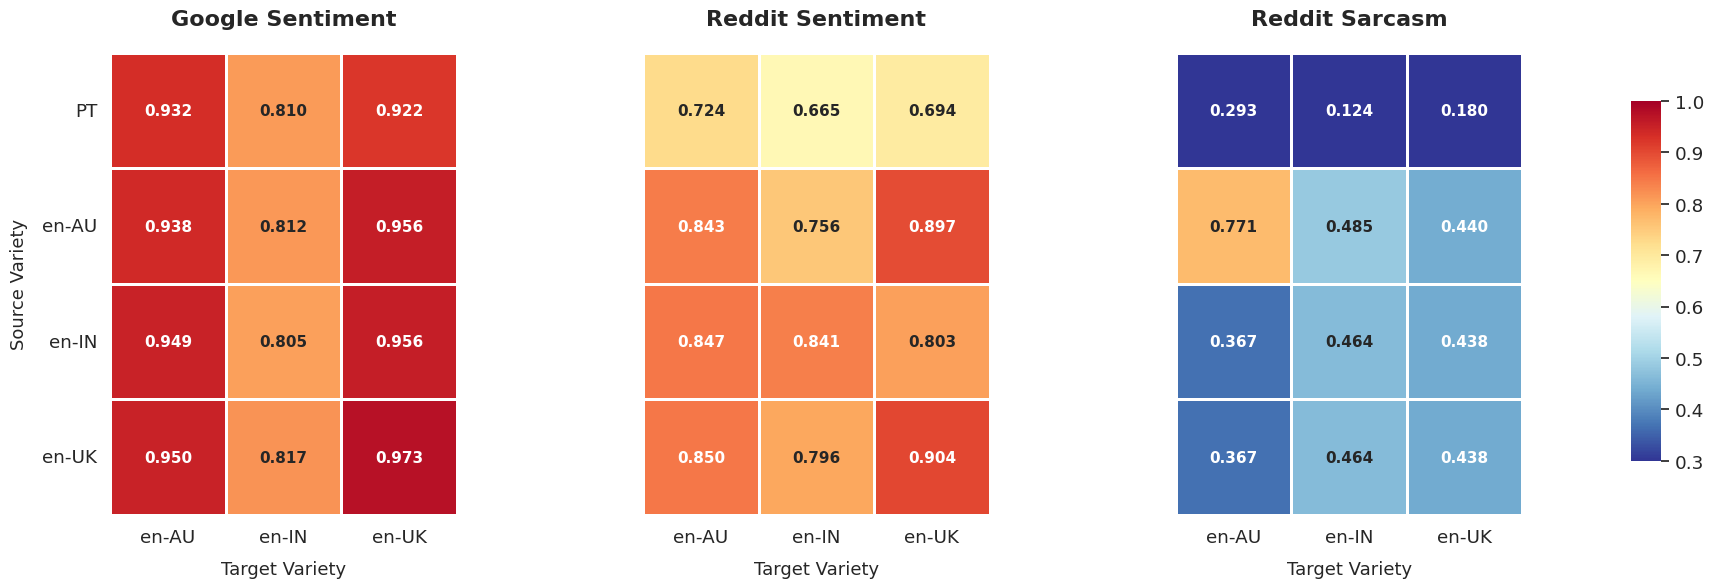

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Load the data
# Using the uploaded file name
results_csv_path = '/content/drive/MyDrive/mistral_besstie_results/mistral_besstie_results_partial.csv'
df = pd.read_csv(results_csv_path)

# Clean strings to ensure no mismatches
df['task'] = df['task'].str.strip()
df['trained_on'] = df['trained_on'].str.strip()
df['tested_on'] = df['tested_on'].str.strip()

# 2. Define the exact order for the paper's layout
# Varieties found in your CSV: en-AU, en-IN, en-UK
varieties = ['en-AU', 'en-IN', 'en-UK']
row_order =  ['PT']+varieties   # Source varieties + PT baseline at the bottom
col_order = varieties           # Target varieties

# Task order usually follows the difficulty/alphabetical: Sarcasm -> Sentiment
tasks_to_plot = ['google-sentiment', 'reddit-sentiment', 'reddit-sarcasm']
titles = ['Google Sentiment','Reddit Sentiment','Reddit Sarcasm']

# 3. Setup the 1x3 Figure
sns.set_theme(style="white", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Shared colorbar axis
cbar_ax = fig.add_axes([.92, .2, .015, .6])

for i, task_name in enumerate(tasks_to_plot):
    ax = axes[i]

    # Filter and Pivot
    task_df = df[df['task'] == task_name].copy()

    # pivot_table handles potential duplicate entries by taking the mean
    pivot_df = task_df.pivot_table(
        index='trained_on',
        columns='tested_on',
        values='f1_score',
        aggfunc='mean'
    )

    # Reindex to force the correct paper order (Source vs Target)
    pivot_df = pivot_df.reindex(index=row_order, columns=col_order)

    # Plot Heatmap
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".3f",
        cmap="RdYlBu_r",     # Changed to Yellow-Orange-Red palette
        vmin=0.3, vmax=1.0, # Standardized range for cross-task comparison
        ax=ax,
        cbar=(i == 0),
        cbar_ax=cbar_ax if i == 0 else None,
        square=True,
        linewidths=1,
        linecolor='white',
        annot_kws={"size": 11, "weight": "bold"}
    )

    # Formatting
    ax.set_title(titles[i], fontweight='bold', fontsize=16, pad=20)
    ax.set_xlabel("Target Variety", fontsize=13, labelpad=10)

    if i == 0:
        ax.set_ylabel("Source Variety", fontsize=13, labelpad=10)
    else:
        ax.set_ylabel("")

    # Rotate labels for better readability
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', rotation=0)

plt.subplots_adjust(right=0.9, wspace=0.1)
plt.savefig("mistral_besstie_heatmaps_refined.png", dpi=300, bbox_inches='tight')
print("Heatmaps saved to mistral_besstie_heatmaps_refined.png")

## Conclusion

This notebook has successfully replicated the BESSTIE benchmark fine-tuning process using Mistral-2B-Instruct with QLoRA quantization. The results show cross-variety performance across three English varieties and three different tasks.

### Key Outputs:
1. Trained LoRA adapters saved in `./mistral_besstie_outputs/`
2. Results CSV and JSON saved in `./mistral_besstie_results/`
3. Heatmap visualizations showing F1-scores for all variety combinations
4. Summary statistics comparing same-variety vs cross-variety performance